In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from statsmodels.nonparametric.kernel_regression import KernelReg
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
def find_extrema(s, bw='cv_ls'):
    """
    Input:
        s: prices as pd.series
        bw: bandwith as str or array like
    Returns:
        prices: with 0-based index as pd.series
        extrema: extrema of prices as pd.series
        smoothed_prices: smoothed prices using kernel regression as pd.series
        smoothed_extrema: extrema of smoothed_prices as pd.series
    """
    # Copy series so we can replace index and perform non-parametric
    # kernel regression.
    prices = s.copy()
    prices = prices.reset_index()
    prices.columns = ['date', 'price']
    prices = prices['price']

    kr = KernelReg(
        [prices.values],
        [prices.index.to_numpy()],
        var_type='c', bw=bw
    )
    f = kr.fit([prices.index])

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less)[0]
    local_max_min = np.sort(
        np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i > 1) and (i < len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i > 1) and (i < len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices


def find_patterns(extrema, max_bars=35):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        patterns: patterns as a defaultdict list of tuples
        containing the start and end bar of the pattern
    """
    patterns = defaultdict(list)

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)+1):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])
        
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (max(e1, e3, e5) > min(e2, e4)):

            patterns['RBOT'].append((window.index[0], window.index[-1]))

    return patterns


def plot_window(prices, extrema, smooth_prices, smooth_extrema, ax=None):
    """
    Input: data from find_extrema
    Output: plots window for actual and smoothed prices and extrema
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    prices.plot(ax=ax, color='dodgerblue')
    ax.scatter(extrema.index, extrema.values, color='red')
    smooth_prices.plot(ax=ax, color='lightgrey')
    ax.scatter(smooth_extrema.index, smooth_extrema.values, color='lightgrey')

## Designing a Head and Shoulders Short Trade Strategy

### Formatting the data to test the strategy

In [35]:
def head_and_shoulders(extrema, index, max_bars=35, shoulder_sensitivity=0.03):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        dates: list of dates containing the start and end bar of the pattern
    """
    dates = []

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)+1):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])
        
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= shoulder_sensitivity*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= shoulder_sensitivity*np.mean([e1, e5])):
            
            #dates.append((index[window.index[0]], index[window.index[-1]]))
            dates.append([index[window.index[0]], index[window.index[-1]]])
            
    return dates

def obtain_pattern_data(data, max_bars, shoulder_sensitivity):
    
    pattern_data = [[0, 0]]

    dates = []

    for i in range(0, len(data)):

        # indexing the prices of interest
        prices = data["Close"][i:i+max_bars]

        # finding the extrema
        extrema, _, _, _ = find_extrema(prices, bw=[0.85])

        # only run head and shoulders when there are 5 extrema
        if len(extrema) >= 5:  

            # detecting the head and shoulders pattern
            dates = head_and_shoulders(extrema, prices.index, max_bars, shoulder_sensitivity)

        # checking if dates has any contents
        if len(dates) >= 1:

            # ensuring duplicate patterns are not saved
            if dates != pattern_data[-1][1]:

                # setting the pattern region as a variable
                pattern_region = data["Close"].loc[dates[0][0]:dates[0][1]]

                # the last two values are the target entry point and the stoploss - latter set to the pattern's head
                pattern_data.append([prices.index[-1], dates, pattern_region.min(), pattern_region.max()])

    return pattern_data[1:]

def obtain_entry_idx(df, detection_dates, pattern_data):

    idx_activate = []
    pattern_data_idx = []

    for i in range(len(pattern_data)):
        nxt_10_days = lite.loc[detection_dates[i]:detection_dates[i]+timedelta(days=10)].Close.le(pattern_data[i][2])

        try: 
            val = nxt_10_days[nxt_10_days == True].idxmin()
            idx_activate.append(val)
            pattern_data_idx.append(i)

        except:
            pass
        
    return idx_activate, pattern_data_idx

def format_strategy_data(data, max_bars, target_profit, shoulder_sensitivity):
    
    # obtaining pattern data
    pattern_data = obtain_pattern_data(data, max_bars, shoulder_sensitivity)

    # obtaining all potential patterns
    detection_dates = [pattern_data[i][0] for i in range(len(pattern_data))]

    # obtaining indices to initate positions, and idx of pattern_data list they correspond to
    idx_activate, sig_idx = obtain_entry_idx(data, detection_dates, pattern_data)

    # initialising unique strategy variables
    data["PatternDetected"] = 0
    data["GoShort"] = 0
    data["StopLoss"] = 0
    data["PosTarget"] = 0 

    # storing indicator on dates when the pattern was detected
    data.loc[detection_dates, "PatternDetected"] = 1

    # storing indicator on dates to initate short position
    data.loc[idx_activate, "GoShort"] = 1

    # using sig_idx list to store stoploss variables stored in pattern_data 
    stoplosses = [pattern_data[sig_idx[i]][3] for i in range(len(sig_idx))]

    # storing stoploss and position targets for each short position
    for i in range(len(idx_activate)):
        data.loc[idx_activate[i], "StopLoss"] = stoplosses[i] 
        data.loc[idx_activate[i], "PosTarget"] = data.loc[idx_activate[i]].NDOpen * (1 - target_profit)

    return data

In [36]:
def format_data(data):
    """
    Strategy agnostic formatting of the data. Adds two columns: 
    - NDOpen: Next day open
    - NDDate: Next day date

    In daily strategies decisions are made on this price and this date. This is called inside the constructor of this
    class.
    """

    # STRATEGY AGNOSTIC COLUMNS
    nddate = data.index.values[1:] # tmp array for next day dates
    data["NDOpen"] = data.Open.shift(-1) # next day open: the price on which trade decisions made at the prev close are taken - with a laplacian perturbation added using modify_open()
    data = data.dropna() # dropping nan to make space for date[1:] values converted into datetime values 
    data["NDDate"] = pd.to_datetime(nddate) # next day date: the date on which trade decisions made at prev close are taken

    return data

In [37]:
lite = yf.Ticker("LITE").history(period="30y")
lite = format_data(lite)
max_bars = 35
target_profit = 0.05
shoulder_sensitivity = 0.03 # the lower this is, the closer the shoulder peaks and troughs need to be together
lite = format_strategy_data(lite, max_bars, target_profit, shoulder_sensitivity)

### Looking at Go Short Trigger Points

In [38]:
lite[lite["GoShort"] == 1]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,NDOpen,NDDate,PatternDetected,GoShort,StopLoss,PosTarget
Date,,,,,,,,,,,,,
2016-04-18,26.830000,27.049999,25.610001,25.940001,521600,0,0,25.870001,2016-04-19,1,1,27.459999,24.576501
2016-10-27,40.799999,41.500000,38.500000,38.900002,2157400,0,0,37.500000,2016-10-28,0,1,44.500000,35.625000
2017-08-04,61.599998,62.349998,58.099998,58.849998,2878000,0,0,60.000000,2017-08-07,0,1,67.949997,57.000000
2018-04-23,59.549999,60.099998,53.500000,54.450001,5555600,0,0,54.799999,2018-04-24,0,1,64.300003,52.059999
2018-05-24,63.000000,63.299999,61.599998,62.299999,851000,0,0,62.349998,2018-05-25,1,1,64.500000,59.232499
2018-10-04,60.830002,61.000000,58.790001,59.360001,1134200,0,0,58.900002,2018-10-05,1,1,63.150002,55.955001
2021-01-29,97.320000,97.970001,93.410004,93.800003,1589900,0,0,95.860001,2021-02-01,0,1,108.930000,91.067001
2021-06-18,80.839996,81.250000,79.720001,80.019997,1008200,0,0,80.519997,2021-06-21,0,1,81.940002,76.493997
2021-07-15,82.449997,82.794998,80.570000,81.330002,537000,0,0,81.320000,2021-07-16,0,1,83.980003,77.254000


### Designing Process and MonitorPositions

In [ ]:
def process(data):
    
    if data.GoShort == 1:
        num_units = int(np.floor((self.pos_size * self.cash_available) / data.Price.values[0]))
        
        if num_units == 0:
                    return 0
            
         # cash check - acts as a lid on opening new positions
        if (self.cash_available - num_units*data.Price.values[0]) > self.cash_buffer:

            return num_units, "Short"
        
        else:
            return 0
        
    return 0

def monitorPosition(data, position):
    
    if data.Price.values[0] <= position.PosTarget.values[0]:

        return True
    
    elif data.Price.values[0] >= position.StopLoss.values[0]:
        
        return True
        
    else:
        
        return False

# Example of the code running retrospectively 
- This is useful for studying the behaviour of the asset and identifying common patterns

defaultdict(list,
            {'TTOP': [(7, 30),
              (18, 32),
              (716, 727),
              (1200, 1207),
              (1226, 1238)],
             'TBOT': [(10, 31),
              (130, 139),
              (467, 481),
              (1194, 1206),
              (1220, 1235),
              (1302, 1318),
              (1427, 1445)],
             'IHS': [(58, 70),
              (139, 150),
              (187, 194),
              (369, 383),
              (541, 559),
              (736, 747),
              (1318, 1330),
              (1456, 1474),
              (1478, 1495),
              (1500, 1513)],
             'BTOP': [(89, 103),
              (148, 161),
              (437, 457),
              (632, 648),
              (879, 888),
              (883, 903),
              (1002, 1018),
              (1328, 1354),
              (1473, 1483),
              (1477, 1493),
              (1512, 1534)],
             'HS': [(172, 183),
              (299, 317),
           

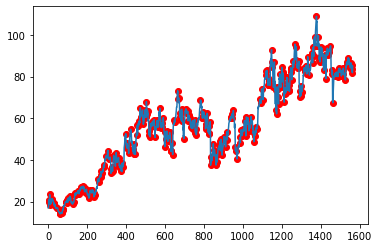

In [28]:
extrema, prices, smooth_extrema, smooth_prices = find_extrema(lite["Close"], bw=[0.85])
patterns = find_patterns(extrema, max_bars=35)
plt.plot(prices)
plt.scatter(extrema.index, extrema, color="red")
patterns